# Phase 2 : Physics and realism

**Problem of Phase 1:** The cars had instantaneous acceleration and deceleration at any moment. That is physically impossible !

In this updated model, we introduce
1.  **Reaction time ($\tau$) :** There is a lag between the driver seeing, taking action, and the action being done by the car(inertia)
2.  **Time till Collision (TTC):** Driver is not replicating the speed of the leader, but rather keeping a distance using TTC(Time till collision), a metric that is in seconds, and can be used to derive the distance a driver will keep given a speed.
### Governing equations
We change the ODE so that we have control over **acceleration** and not *speed*
* **Position :** $x(t+dt) = x(t) + v(t) \cdot dt$
* **Speed (v) :** $v(t+dt) = v(t) + a(t) \cdot dt$
* **Acceleration :** $a(t+dt) = a(t) + \frac{dt}{\tau} (u(t) - a(t))$

### Imports

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

## Parameters

We define model parameters for reference 

#### Car parameters
- `N`: Number of cars in the simulation
- `L`: Length of a car in the simulation
- `spacing`: The initial spacing between the cars when starting the simulation

#### Physical parameters
- `V_target`: The target speed a car wants to reach
- `a_max`: Maximum acceleration or deceleration a car can have

#### Driver behaviour parameters
- `k`: Driver agressivity(how much will it accelerate instantly if there is space)
- `t_reac`: Reaction time, expresses the reaction lag between the perception and action by the driver and the car
- `ttc`: Time to collision (How many seconds will it have till collision if the vehicle in front stops instantly and he keeps the same speed)

#### Simulation params
- `dt`: Time step
- `T_total`: Total simulation time

In [ ]:
# Default parameters for reference
# Paramètres des voitures
N_ref = 50                      # Nombre de voitures
L_ref = 5.0                     # Longueur d'une voiture 
spacing_ref = 40.0              # Espacement de départ

# Paramètres Physiques
V_target_ref = 30.0             # Vitesse qu'on veut atteindre
a_max_ref = 10.0                # Accelation max

# Paramètres de Comportement
k_ref = 0.5                     # Agressivité en accélération
tau_ref = 0.5                   # Temps de reponse (temps de réponse en s)
ttc_ref = 2.                     # Time to collision (s)
# # Paramètres Temporels
dt = 0.05                       # Pas de temps
T_total = 200.0                 # Durée totale

In [60]:
# Define a structure for simulation parameters
def create_params(N=N_ref, L=L_ref, spacing=spacing_ref, V_target=V_target_ref, t_reac=tau_ref, a_max=a_max_ref, k=k_ref, ttc=ttc_ref):
    """Create a dictionary of simulation parameters. Defaults are set to reference values."""
    
    if not isinstance(V_target, np.ndarray):
        V_target = np.ones(N) * V_target
    if not isinstance(t_reac, np.ndarray):
        t_reac = np.ones(N, np.float32) * t_reac
    if not isinstance(ttc, np.ndarray):
        ttc = np.ones(N, dtype=np.float32) * ttc
    if not isinstance(k, np.ndarray):
        k = np.ones(N, dtype=np.float32) * k

    params = {
        'N': N,
        'L': L,
        'spacing': spacing,
        'V_target': V_target,
        't_reac': t_reac,
        'a_max': a_max,
        'k': k,
        'ttc': ttc,
    }
    return params

default_params = create_params()

## Simulation

##### Helper function to calculate the acceleration

In [61]:
def a_adjust(vitesses, positions, params):
    """Compute acceleration adjustments for vehicles based on their velocities and positions."""
    u = np.zeros(params['N'])
    u[0] = (params['V_target'][0] - vitesses[0])

    # Calculate current gap and desired gap
    alpha = (positions[:-1]- positions[1:]) - params['L']
    alpha_want = np.maximum(vitesses[1:] * params['ttc'][1:], 2*params['L'])

    # l > 1.0 : accélère
    # l < 1.0 : freine
    l = np.clip(alpha / alpha_want, 0.0, 1.0)

    a_norm = np.minimum(params['k'][1:] * (params['V_target'][1:] - vitesses[1:]), params['a_max'])
    a_crit = -params['a_max']

    # interpolation
    u[1:] = l * a_norm + (1 - l) * a_crit
    return u

##### Main simulation function

In [62]:
def simulate(params, brake_moments):
    """Simulate the traffic flow based on given parameters and brake moments.
    Arguments:
    - params: Dictionary containing simulation parameters.
    - brake_moments: List of tuples (moment, duration, force) indicating when brakes are applied to the leading car
    Returns:
    - X: Positions of cars over time.
    - V: Velocities of cars over time.
    - crash: Tuple (time, position) if an accident occurs, else None.
    """
    nb_steps = int(T_total / dt)

    # Extract parameters
    N = params['N']
    L = params['L']
    spacing = params['spacing']
    V_target = params['V_target']
    k = params['k']

    X = np.zeros((nb_steps, N))
    V = np.zeros((nb_steps, N))
    A = np.zeros((nb_steps, N))

    # Initial positions
    X[0] = -np.arange(N) * spacing
    V[0] = V_target

    crash = None

    for i in range(nb_steps - 1):
        t = i * dt

        # Check for brake
        perturb = 0
        for moment, duration, force in brake_moments:
            if moment < t < moment + duration:
                perturb = force
                break
        # perturb = (10.0 < t < 13.0)

        # get acceleration
        u = a_adjust(V[i], X[i], params)     
        if perturb>0:
            u[0] = -perturb
        else:
            u[0] = k[0] * (V_target[0] - V[i][0])

        # step  
        A[i+1] = A[i] + (dt / params['t_reac']) * (u - A[i])
        V[i+1] = np.maximum(V[i] + A[i+1] * dt, 0.0)
        X[i+1] = X[i] + V[i+1] * dt

        # Check for accidents
        alphas = (X[i+1, :-1] - X[i+1, 1:]) - L

        if np.any(alphas < 0):

            idx_crash = np.where(alphas < 0)[0][0] + 1
            pos_crash = X[i+1, idx_crash]
            crash = (t, pos_crash)

            # Stop simulation
            X[i+1:] = X[i+1]
            V[i+1:] = V[i+1]
            break

    return X, V, crash

hist_X, hist_V, crash_data = simulate(default_params, [(10, 3, 6)])
print(f"Simulation completed. Accident : {'Yes' if crash_data else 'No'}")

Simulation completed. Accident : No


### Visualization

#### Simple plots: Position over time

In [63]:
def visualize_trajectories(params, brake_force, ax):

    X, V, crash_info = simulate(params, [(10, 3, brake_force)])

    time_grid = np.arange(len(X)) * dt

    for i in range(0, params['N'], 2):
        ax.plot(time_grid, X[:, i], color='black', alpha=0.3, linewidth=1)

    if crash_info:
        c_time, c_loc = crash_info
        ax.scatter(c_time, c_loc, c='red', s=100, marker='X', zorder=5)
        ax.set_title(f"Simulation Frozen t={c_time:.2f}s (CRASH)", color='red', fontweight='bold')
        ax.axvspan(c_time, T_total, color='red', alpha=0.1)
    else:
        ax.set_title("Trajectories", color='green', fontweight='bold')

    ax.set_ylabel("Position (m)")
    ax.set_xlabel("Time (s)")

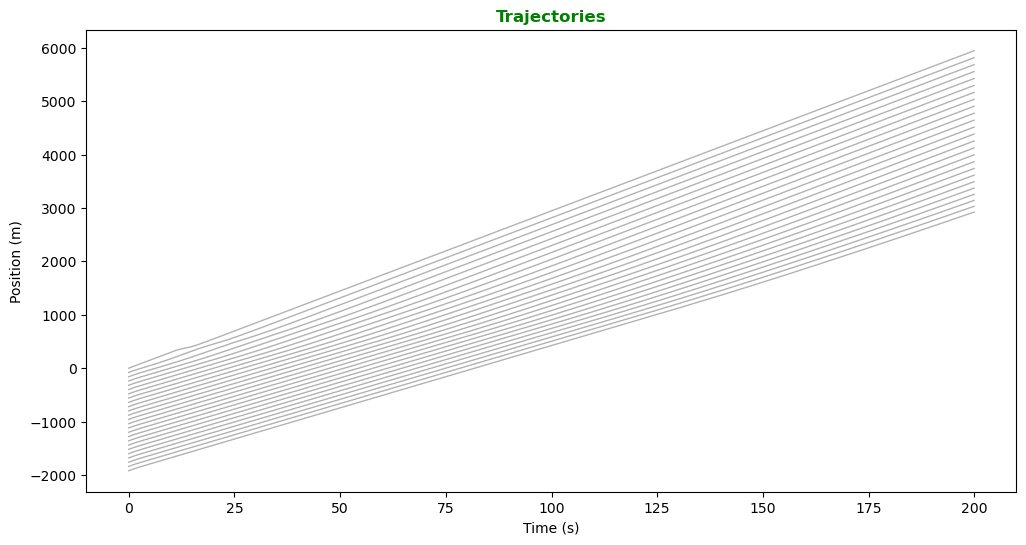

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))
visualize_trajectories(create_params(), brake_force=6, ax=ax)

In [65]:
def get_simulation_data(params, brake, brake_moments):
    """Call simulation with given parameters and brake settings."""
    brake_force, brake_time = brake
    if brake_moments is None:
        brake_moments = []
    brakes = [(m, brake_time, brake_force) for m in brake_moments]
    return simulate(params, brakes)

#### Main plots: 
    - Positions of cars on the road
    - Velocities of cars
    - Distances between cars

In [66]:
def visualize(data, params, brake_moments, t, return_data=False):
    """Visualize the traffic simulation at a specific time t.
        3 Plots are created:
        - Positions of cars on the road
        - Velocities of cars
        - Distances between cars
    Arguments:
    - data: Tuple (X, V, crash_info) from simulation.
    - params: Dictionary of simulation parameters.
    - brake_moments: List of times when brakes were applied.
    - t: Time at which to visualize the state.
    - return_data: If True, return the figure and axes instead of displaying.

    Returns:
    - If return_data is True, returns (fig, axes, plot_elements, data)
    - Else, displays the plot.
    """

    X, V, crash_info = data
    
    if brake_moments is None:
        brake_moments = []
    
    crash_moment = crash_info[0] if crash_info else T_total
    brake_points = X[[int(m / dt) for m in  [m for m in brake_moments if m < crash_moment]], 0]
    road_min = -params['N'] * params['spacing'] -100
    road_max = np.max(params['V_target']) * T_total +100
    
    # Get State
    t_idx = int(t / dt)
    if t_idx >= len(X): t_idx = len(X) - 1
    x_now = X[t_idx]
    v_now = V[t_idx]
    

    fig, (ax_pos, ax_vel, ax_alphas) = plt.subplots(3, 1, figsize=(16, 12))
    
    # Position Plot (ax_pos)
    ax_pos.hlines(0, road_min, road_max, colors='gray', linestyles='-', linewidth=2, alpha=0.3)
    ax_pos.vlines(brake_points, color='orange', linestyle='--', linewidth=2, label='Braking Point', ymin=-3, ymax=3)
    
    # Draw Crash
    if crash_info:
        c_time, c_loc = crash_info
        if t >= c_time:
            ax_pos.axvline(c_loc, color='red', linestyle=':', linewidth=3, label='CRASH POINT')
            ax_pos.text(c_loc, 1.2, "IMPACT", color='red', fontweight='bold', ha='center')

    # Color mapping
    norm = plt.Normalize(0, 35)
    cmap = plt.cm.RdYlGn
    colors = cmap(norm(v_now))
    
    # Crash Coloring
    if params['N'] > 1:
        gaps = x_now[:-1] - x_now[1:] - params['L']
        crashed_indices = np.where(gaps < 0)[0] + 1
        if len(crashed_indices) > 0:
            colors[crashed_indices] = np.array([1.0, 0.0, 0.0, 1.0])

    # Draw Cars
    sc = ax_pos.scatter(x_now, np.zeros_like(x_now), c=colors, s=30, edgecolors='black', zorder=3)
    
    ax_pos.set_title(f"Traffic State (t={t:.1f}s)", fontsize=14)
    ax_pos.set_ylim(-1, 1)
    ax_pos.set_yticks([])
    ax_pos.set_xlabel("Road Position (m)")
    ax_pos.set_xlim(road_min, road_max)
    ax_pos.legend(loc='upper right')
    
    # Speeds (ax_vel)
    bars_vel = ax_vel.bar(-np.arange(len(v_now)), v_now, width=.5, color=cmap(norm(v_now)), alpha=0.8, align='center')
    ax_vel.set_ylabel("Speed")
    ax_vel.set_ylim(0, 35)


    dists = np.zeros(2*len(x_now)-1)
    dists[1::2] =  x_now[:-1] - x_now[1:]

    bars_alpha = ax_alphas.bar(-np.arange(2*len(x_now)-1),dists, width=1, alpha=0.8, align='center')
    
    if return_data:
        plt.close(fig)
        return fig, (ax_pos, ax_vel, ax_alphas), (sc, bars_vel, bars_alpha), (X, V, crash_info)

    plt.tight_layout()
    plt.show()

#### Plots into animations

In [67]:
from matplotlib import animation
from IPython.display import HTML


def animate(params, brake, brake_moments=None):
    """Create an animation of the traffic simulation.
    Arguments:
    - params: Dictionary of simulation parameters.
    - brake: Tuple (brake_force, brake_time).
    - brake_moments: List of times when brakes are applied.
    Returns:
    - anim: Matplotlib animation object.
    """
    
    data = get_simulation_data(params, brake, brake_moments)
    fig, (ax_pos, _, _), (sc, bars_vel, bars_alpha), (X, V, _) = visualize(data, params, brake_moments, 0, return_data=True)
    
    norm = plt.Normalize(0, 35)
    cmap = plt.cm.RdYlGn

    def update(frame):
        x, v = X[frame], V[frame]
        
        # Update positions and colors
        colors = cmap(norm(v))
        if params['N'] > 1:
            gaps = x[:-1] - x[1:] - params['L']
            crashed = np.where(gaps < 0)[0] + 1
            if len(crashed) > 0: colors[crashed] = [1, 0, 0, 1]
            
        sc.set_offsets(np.c_[x, np.zeros_like(x)])
        sc.set_facecolors(colors)
        
        # Update bars
        for bar, h, c in zip(bars_vel, v, colors):
            bar.set_height(h)
            bar.set_color(c)
            
        dists = np.zeros(2*len(x)-1)
        dists[1::2] = x[:-1] - x[1:]
        for bar, h in zip(bars_alpha, dists):
            bar.set_height(h)
            
        # ax_pos.set_title(, fontsize=14)
        ax_pos.set_title(
            f"Traffic State (t={frame*dt:.1f}s) \n"
            f"V_target={params['V_target'][0]:.1f} m/s | "
            f"t_reac={params['t_reac'][0]:.2f}s | "
            f"ttc={params['ttc'][0]:.1f}s | "
            f"brake={brake[0]:.1f} for {brake[1]:.1f}s"
        )
        return [sc, *bars_vel, *bars_alpha]

    anim = animation.FuncAnimation(fig, update, frames=range(0, len(X), 50), interval=200, blit=False)

    return anim

### Interactive simulation

In [72]:
# Brake moments for the interactive plots
brake_moments = [10.]

# last simulation parameters
last_sim_params = None
last_sim_data = None

def interact(V_max, t_reac, ttc, brake_force, brake_time, t):
    global last_sim_params, last_sim_data
    
    cur_params = (V_max, t_reac, ttc, brake_force, brake_time)
    params = create_params(V_target=V_max, t_reac=t_reac, ttc=ttc)

    if last_sim_params != cur_params:
        last_sim_data = get_simulation_data(params, (brake_force, brake_time), brake_moments)
        last_sim_params = cur_params
        # print("Simulation updated")
    visualize(last_sim_data, params, brake_moments, t)

In [ ]:
style = {'description_width': 'initial'}
layout = widgets.Layout(width='90%')
ui = widgets.interactive(
    interact,
    V_max=widgets.FloatSlider(min=0.0, max=50.0, step=1.0, value=default_params['V_target'][0], description='V_max', style=style, layout=layout),
    t_reac=widgets.FloatSlider(min=0.01, max=1.0, step=0.01, value=default_params['t_reac'][0], description='t_reac', style=style, layout=layout),
    ttc=widgets.FloatSlider(min=0.1, max=2.5, step=0.1, value=default_params['ttc'][0], description='ttc', style=style, layout=layout),
    brake_time=widgets.FloatSlider(min=1.0, max=50.0, step=0.5, value=5.0, description='Brake Duration', style=style, layout=layout),
    brake_force=widgets.FloatSlider(min=1.0, max=a_max_ref, step=1.0, value=5.0, description='Brake Force', style=style, layout=layout),
    t=widgets.FloatSlider(min=0.0, max=T_total, step=0.5, value=0.0, description='Time', style=style, layout=layout)
)

# Export Button
btn_export = widgets.Button(description="Export Animation", icon="download")
out_export = widgets.Output()

def on_export_click(b):
    with out_export:
        out_export.clear_output()
        print("Generating animation... please wait.")
        
        k = ui.kwargs
        p = create_params(V_target=k['V_max'], t_reac=k['t_reac'], ttc=k['ttc'])
        brake = (k['brake_force'], k['brake_time'])
    
        try:
            anim = animate(p, brake, brake_moments)
            filename = (
                f"traffic_V{p['V_target'][0]}_tr{p['t_reac'][0]}_ttc{p['ttc'][0]}"
                f"_bf{brake[0]}_bd{brake[1]}.mp4"
            )
            writer = animation.FFMpegWriter(fps=15, bitrate=2000)
            anim.save(filename, writer=writer)
            print(f"Done! Saved to {filename}")
        except NameError:
            print("Error: Please run the cell below to define 'animate' first.")

btn_export.on_click(on_export_click)

display(ui, btn_export, out_export)

interactive(children=(FloatSlider(value=30.0, description='V_max', layout=Layout(width='90%'), max=50.0, step=…

Button(description='Export Animation', icon='download', style=ButtonStyle())

Output()